In [11]:
'''Setup:

Agent Based Model for PA in group based social networks

Agents are users
  users have two parameters : post rate & comment rate
    poisson random variables

Forums create threads where users interact
  
create interaction matrix between users, records number of interactions over given interval

measurements are number of interactions between agents for a given time interval

at each time step:
  initialize random number of new users
  each new user joins random number of groups (not based on group size)
  for each user:
    random number of posts based on user post rate, placed in user groups based on group size
    gather list of all posts in every group user is part of 
      add comments based on comment rate, proportional to most active threads (highest number of existing comments)
        for each comment choose a random user in the thread that this user 'replied' to, add to interaction matrix
'''

"Setup:\n\nAgent Based Model for PA in group based social networks\n\nAgents are users\n  users have two parameters : post rate & comment rate\n    poisson random variables\n\nForums create threads where users interact\n  \ncreate interaction matrix between users, records number of interactions over given interval\n\nmeasurements are number of interactions between agents for a given time interval\n\nat each time step:\n  initialize random number of new users\n  each new user joins random number of groups (not based on group size)\n  for each user:\n    random number of posts based on user post rate, placed in user groups based on group size\n    gather list of all posts in every group user is part of \n      add comments based on comment rate, proportional to most active threads (highest number of existing comments)\n        for each comment choose a random user in the thread that this user 'replied' to, add to interaction matrix\n"

In [100]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
from math import floor

In [154]:
# classes
class Group:
    def __init__(self):
        # Initialize a group with an ID and a dictionary to track user interactions
        self.id = 0
        self.interactions = {}
        self.growth = [0] * num_timesteps

class User:
    def __init__(self, alpha, beta):
        # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
        self.id = 0
        self.groups = []
        self.interaction_history = []
        self.preferences = stats.beta(alpha, beta)

    def update_preferences(self):
        # Update user's preferences based on group interactions
        if not self.groups:
            self.updated_preferences = np.array([1])
            return

        total_size = sum([len(group.interactions) for group in self.groups])
        if total_size == 0:
            self.groups_cdf = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            # self.groups_cdf = np.array(sorted([len(group.interactions) / total_size for group in self.groups])[::-1])
            self.groups_cdf = np.array([len(group.interactions) / total_size for group in self.groups])

        # self.updated_preferences = np.convolve(self.preferences.pdf(np.linspace(0, 1, len(self.groups))), self.groups_cdf, mode='same')
        self.updated_preferences = np.convolve(self.preferences.pdf(self.groups_cdf), self.groups_cdf, mode='same')
        # self.updated_preferences = self.preferences.pdf(self.groups_cdf) * self.groups_cdf

        # print('Groups:',len(self.groups))
        # print('Groups CDF:',self.groups_cdf)
        # print('Before prefs:',self.updated_preferences)
        # print('Before Sum:',np.sum(self.updated_preferences))

        # if sum is 0, return uniform preferences
        if np.sum(self.updated_preferences) == 0:
            self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        
        # normalize then set any NaNs to 0
        self.updated_preferences /= np.sum(self.updated_preferences)
        self.updated_preferences[np.isnan(self.updated_preferences)] = 0

        # add difference to a random preference to make sum 1 to account for rounding errors
        if np.sum(self.updated_preferences) != 1.0:
            rand_pref = np.random.choice(self.updated_preferences)
            rand_pref = rand_pref + (1 - np.sum(self.updated_preferences))
            
        # print('After prefs:',self.updated_preferences)
        # print('After Sum:',np.sum(self.updated_preferences), '\n')

        # if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
        #     self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        # else:
        #     self.updated_preferences /= np.sum(self.updated_preferences)
        
        # while np.isnan(self.updated_preferences).any():
        #     self.updated_preferences[np.isnan(self.updated_preferences)] = 0
        #     if np.sum(self.updated_preferences) == 0:
        #         self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        # self.updated_preferences /= np.sum(self.updated_preferences)

    def join_group(self, group):
        # Add a group to the user's group list and set initial interactions to 0
        self.groups.append(group)
        group.interactions[self] = 0

    def interact(self, group: Group):
        # Record an interaction with the specified group
        group.interactions[self] += 1
        self.interaction_history.append(group.id)

# Initialize lists to store users and groups
users = []
groups = []
num_groups = len(groups)

# Define simulation parameters
user_growth_rate = 0.05
group_join_rate = 0.00625
new_group_threshold = 0.005
interaction_threshold = 0.5
num_timesteps = 100
alpha_hyperparameter = 10
beta_hyperparameter = 10 
initial_users = 10
initial_groups = 5

# Data structure for regression analysis
data_for_regression = []
group_tracking = {}

# Create initial users and groups
for _ in range(initial_users):
    user = User(np.random.uniform(1, alpha_hyperparameter), np.random.uniform(1, beta_hyperparameter))
    users.append(user)
    user.id = len(users)

for _ in range(initial_groups):
    group = Group()
    groups.append(group)
    group.id = len(groups) #+ 1

# Initial user-group interactions
for user in users:
    for _ in range(floor(stats.expon.rvs(group_join_rate))):
        group = np.random.choice(groups)
        user.join_group(group)
    user.update_preferences()


In [155]:
# Main simulation loop
for time in range(num_timesteps):
    print('Time:',time)
    for _ in range(floor(stats.expon.rvs(user_growth_rate))): 
        user = User(np.random.uniform(1, alpha_hyperparameter), np.random.uniform(1, beta_hyperparameter))
        users.append(user)
        user.id = len(users)
        
    for user in users:
        for _ in range(floor(stats.expon.rvs(group_join_rate))):
            if np.random.uniform() < new_group_threshold:
                group = Group()
                user.join_group(group)
                groups.append(group)
                group.id = len(groups) #+ 1
                
            else:
                group = np.random.choice(groups)
                user.join_group(group) 

        if user.groups:
            user.update_preferences()
        else:
            user.updated_preferences = np.array([1])

        num_groups = len(groups)

        if (np.random.uniform() < interaction_threshold) and (user.groups):
            group = np.random.choice(user.groups, p=user.updated_preferences)
            user.interact(group)
            current_group = user.interaction_history[-1]
        else:
            user.interaction_history.append(0)
            current_group = user.interaction_history[-1]

        if len(user.interaction_history) > 1:
            previous_group = user.interaction_history[-2]
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            data_for_regression.append([user.id,current_group, *interactions_by_group])
        else:
            previous_group = current_group
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            data_for_regression.append([user.id,current_group, *interactions_by_group])
    
    for group in groups:
        group.growth[time] = sum(group.interactions.values())


Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20
Time: 21
Time: 22
Time: 23
Time: 24
Time: 25
Time: 26
Time: 27
Time: 28
Time: 29
Time: 30
Time: 31
Time: 32
Time: 33
Time: 34
Time: 35
Time: 36
Time: 37
Time: 38
Time: 39
Time: 40
Time: 41
Time: 42
Time: 43
Time: 44
Time: 45
Time: 46
Time: 47
Time: 48
Time: 49
Time: 50
Time: 51
Time: 52
Time: 53
Time: 54
Time: 55
Time: 56
Time: 57
Time: 58
Time: 59
Time: 60
Time: 61
Time: 62
Time: 63
Time: 64
Time: 65
Time: 66
Time: 67
Time: 68
Time: 69
Time: 70
Time: 71
Time: 72
Time: 73
Time: 74
Time: 75
Time: 76
Time: 77
Time: 78
Time: 79
Time: 80
Time: 81
Time: 82
Time: 83
Time: 84
Time: 85
Time: 86
Time: 87
Time: 88
Time: 89
Time: 90
Time: 91
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99


In [156]:
# track group growth over time
for group in groups:
    group_tracking[group.id] = group.growth

group_tracking_df = pd.DataFrame(group_tracking)

Text(0, 0.5, 'Group Growth')

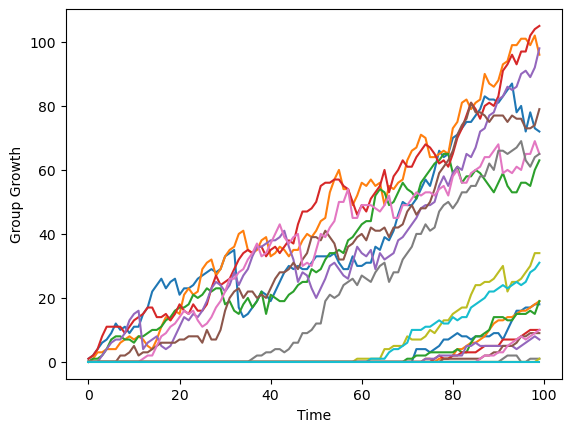

In [159]:
plt.plot(group_tracking_df)
plt.xlabel('Time')
plt.ylabel('Group Growth')

In [ ]:
import stan
import arviz as az
import nest_asyncio
from itertools import chain
nest_asyncio.apply()

N = len(users)
K = len(groups)
D = len(groups)
Y = np.zeros(N)
X = np.zeros((N, D))

for user in users:
    # Filter data for user
    user_data = [row for row in data_for_regression if row[0] == user.id]
    
    final_entry = user_data[-1]
  
    if len(final_entry) - 2 < D:
        final_entry += [0] * (D - len(final_entry) + 2)

    Y[user.id - 1] = final_entry[1]
    X[user.id - 1] = final_entry[2:]

Y = Y.astype(int)

for row in X:
    row /= np.sum(row)

X = np.where(X == 0, 0.0001, X)

stan_code = """
data {
  int K;
  int N;
  int D;
  array[N] int Y;
  matrix[N, D] X;
}
parameters {
  matrix[D, K] beta;
}
model {
  matrix[N, K] x_beta = X * beta;

  to_vector(beta) ~ normal(0, 1);

  for (n in 1:N) {
    Y[n] ~ categorical_logit(x_beta[n]');

  }
}
"""



In [ ]:
model = stan.build(stan_code, data={'K' : K, 'N' : N, 'D' : D, 'Y' : Y, 'X' : X.astype(float)})
fit = model.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sa

In [ ]:
az_data = az.from_pystan(posterior=fit)

In [ ]:
az.summary(az_data, round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
"beta[0, 0]",-0.00,1.04,-1.96,1.95
"beta[0, 1]",0.00,0.99,-1.87,1.84
"beta[0, 2]",0.02,1.01,-2.03,1.81
"beta[0, 3]",0.01,1.03,-1.89,1.94
"beta[0, 4]",0.01,0.99,-1.76,1.87
...,...,...,...,...
"beta[102, 98]",0.01,0.95,-1.79,1.75
"beta[102, 99]",0.01,0.95,-1.91,1.71
"beta[102, 100]",-0.00,1.02,-1.85,1.95
"beta[102, 101]",0.00,1.01,-1.75,1.96


In [ ]:
az.summary(az_data, round_to=2, kind='diagnostics')

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.01,0.02,11455.92,2240.88,1.0
"beta[0, 1]",0.01,0.02,10963.01,2259.52,1.0
"beta[0, 2]",0.01,0.02,12053.45,2608.12,1.0
"beta[0, 3]",0.01,0.02,10505.40,2317.03,1.0
"beta[0, 4]",0.01,0.02,9618.15,2797.85,1.0
...,...,...,...,...,...
"beta[102, 98]",0.01,0.02,11312.32,2763.76,1.0
"beta[102, 99]",0.01,0.02,10890.88,2244.80,1.0
"beta[102, 100]",0.01,0.02,11379.87,2827.65,1.0
"beta[102, 101]",0.01,0.02,11624.94,2749.33,1.0


In [ ]:
coefs = az_data.posterior.beta.mean(axis=(0,1))

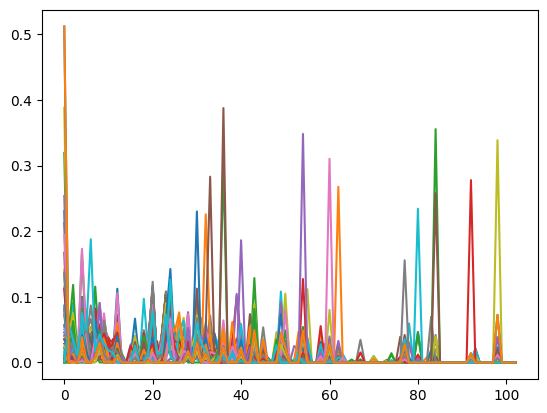

In [ ]:
conv = X @ np.array(coefs)
# set negative values to 0
conv = np.where(conv < 0, 0, conv)
# normalize
for row in conv:
    row /= np.sum(row)


# user preferences ?!?!
for i in range(len(conv)):
  plt.plot(conv[i])